# Minimum ball example - 3 different implementations in Python using MOSEK Fusion

The problem:
$$
\begin{array}{lcl}
\mbox{minimize} & r                                    & \\
\mbox{st}       & \left( \begin{array}{c}
                      r       \\
                      p^i -x  \\
                   \end{array} \right ) \in \mathcal{K}_q, \forall i  & \\
\end{array}
$$


# Version 1 - the simple one

A straightforward implementation

In [1]:
import random
import sys
import mosek

from mosek.fusion import *

random.seed(278) # Makes the script deterministic

d = 2     # Dimmension     
n = 100   # Number of points

# Generate the points
p =  [ [random.gauss(0.,1.) for dd in range(d)] for nn in range(n)]

# p[i]: Is the i'th point i.e. it is stored rowwise
   
with Model("minimal ball enclosing a set of points - primal") as M:

    # M.setLogHandler(sys.stdout)  # Make sure we get some output

    r = M.variable("r", 1, Domain.unbounded())
    x = M.variable("x", d, Domain.unbounded())

    for i in range(n):
        M.constraint(Expr.vstack(r, Expr.sub(p[i],x)), Domain.inQCone())

    M.objective(ObjectiveSense.Minimize, r)
    
    M.solve()
    
    print('Radius: %e\n' % r.level()[0])    

Radius: 2.592944e+00



# A plotting function based on matplotlib

Create a plotting function for plotting purposes

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_points(p, p0=[], r0=0.):
    n,k= len(p0), len(p)
    
    plt.rc('savefig',dpi=120)

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot([ p[i][0] for i in range(k)], [ p[i][1] for i in range(k)], 'b*')
    
    if len(p0)>0:
        ax.plot(  p0[0],p0[1], 'r.')
        ax.add_patch( mpatches.Circle( p0,  r0 ,  fc="w", ec="r", lw=1.5) )
    plt.grid()
    plt.show()
    

# Version 2 - using outer product

In Fusion when we say
$$
A(x) \in \mathcal{K}_q
$$
where $A(x)$ is a 2 dimensional expression then that means each row much be a quadratic cone. 

Recall the i'th row of p is the i'th point.

Therefore, the constraint corresponds to each row of
$$
[e r,p - e x^T] = 
\left [
    \left [ \begin{array}{c} 
                r \\
                r \\
                \vdots \\
            \end{array} 
    \right ], 
    p^T - \left [ \begin{array}{c} 
                    1 \\
                    1 \\
                    \vdots \\
                \end{array} 
        \right ]
        \left [ \begin{array}{c} 
                    x_1 \\
                    x_2 \\
                    \vdots \\
                \end{array} \right ]^T
\right ]
= \left [
\begin{array}{ccc}
r      & p_{11} - x_ 1 & p_{12} - x_2 \\
r      & p_{21} - x_1  & p_{22} - x_2 \\  
\vdots & \vdots        & \vdots       \\  
\end{array}
\right ]
$$
must be in a quadratic cone. e is the vector of all ones.

Radius: 2.592944e+00



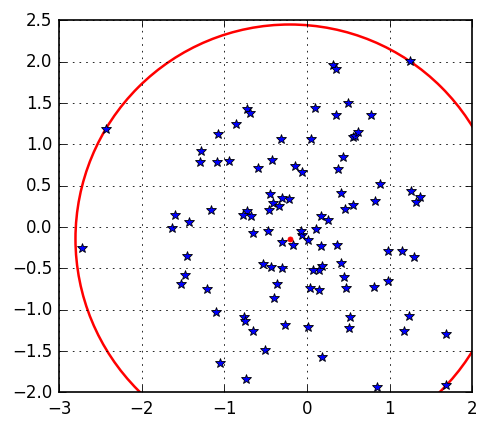

In [3]:
with Model("minimal ball enclosing a set of points - primal") as M:

    # M.setLogHandler(sys.stdout)  # Make sure we get some output

    r = M.variable("r", 1, Domain.unbounded())
    x = M.variable("x", d, Domain.unbounded())
    
    e = [1]*n # Python structure

    # Each row of  [e*r,p-ex'] in a quadratic
    M.constraint(Expr.hstack(Expr.outer(e,r), Expr.sub(p, Expr.outer(e,x))), Domain.inQCone())

    M.objective(ObjectiveSense.Minimize, r)
    
    M.solve()

    print('Radius: %e\n' % r.level()[0])

    plot_points(p,x.level(),r.level())
    

# Version 3 - Using repeat

Same idea as in version 2 but using the repeat operator

In [4]:
with Model("minimal ball enclosing a set of points - primal") as M:

    r = M.variable("r", 1, Domain.unbounded())
    x = M.variable("x", d, Domain.unbounded())

    # Each row of  [e*r,p-ex'] in a quadratic cone
    M.constraint(Expr.hstack(Var.repeat(r,n),Expr.sub(p,Var.repeat(x.transpose(),0,n))), Domain.inQCone())

    M.objective(ObjectiveSense.Minimize, r)
    
    M.solve()

    print('Radius: %e\n' % r.level()[0])

Radius: 2.592944e+00



# Timing and numpy

Let us see how we can time a function. Also let us numpy.

numpy is a base N-dimensional array package. See http://scipy.org.

In [5]:
import time
import numpy

d = 2      # Dimmension     
n = 10000  # Number of points

numpy.random.seed(379)

p = numpy.random.standard_normal(size=(n,d))

with Model("minimal ball enclosing a set of points - primal") as M:
    
    before = time.monotonic()

    r      = M.variable("r", 1, Domain.unbounded())
    x      = M.variable("x", d, Domain.unbounded())

    # Each row of  [e*r,p-ex'] in a quadratic cone
    M.constraint(Expr.hstack(Var.repeat(r,n),Expr.sub(p,Var.repeat(x.transpose(),0,n))), Domain.inQCone())

    M.objective(ObjectiveSense.Minimize, r)
    
    s = time.monotonic() 
    M.solve()
    print('Solve time: %f' % (time.monotonic()-s))
    print('Total time: %f' % (time.monotonic()-before))
    
    print('Radius: %e\n' % r.level()[0])

Solve time: 0.312000
Total time: 4.009000
Radius: 3.902840e+00



Conclusion: Python can be a bit sluggish. Use one of the other Fusion interfaces instead if that is an issue.